# 0.0 - IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import inflection

from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Funcitons 

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data 

In [4]:
df_train_raw = pd.read_csv('data/train.csv', low_memory=False)

# 1.0 - DATA DESCRIPTION

In [5]:
df1 = df_train_raw.copy()

## 1.1 Rename Columns 

In [6]:
cols_old = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
            'Item_Type', 'Item_MRP', 'Outlet_Identifier',
            'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
            'Outlet_Type', 'Item_Outlet_Sales']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions 

In [7]:
print('Number of columns: {}'.format(df1.shape[1]))
print('Number of rows: {}'.format(df1.shape[0]))

Number of columns: 12
Number of rows: 8523


## 1.3 Data Types 

In [8]:
df1.dtypes

item_identifier               object
item_weight                  float64
item_fat_content              object
item_visibility              float64
item_type                     object
item_mrp                     float64
outlet_identifier             object
outlet_establishment_year      int64
outlet_size                   object
outlet_location_type          object
outlet_type                   object
item_outlet_sales            float64
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

item_identifier                 0
item_weight                  1463
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  2410
outlet_location_type            0
outlet_type                     0
item_outlet_sales               0
dtype: int64

## 1.5 Fillout NA 

In [10]:
#========item_weight==============
#create aux item dataframe dataframe
aux1 = df1[['item_identifier', 'item_weight']].groupby(['item_identifier', 'item_weight']).max()
df_aux_item = pd.DataFrame(aux1).reset_index()

#merge aux item dataframe with df1
df1= pd.merge(df1, df_aux_item, how='left', on='item_identifier')
df1.drop('item_weight_x', inplace=True, axis=1)
df1 = df1.rename(columns={'item_weight_y': 'item_weight'})

#substitute NA left with mean products weight
mean_weight = df1['item_weight'].mean()
df1['item_weight'] = df1['item_weight'].fillna(mean_weight)

#============outlet_size=========== 
#replace outlet_identifier == OUT010 size for small based on similar OUT019
df1.loc[df1['outlet_identifier'] == 'OUT010', 'outlet_size'] = 'Small'

#replace outlet_identifier == OUT017 size for small based on similar majority for Supermarket Type1
df1.loc[df1['outlet_identifier'] == 'OUT017', 'outlet_size'] = 'Small'

#replace outlet_identifier == OUT045 size for small based on similar majority for Supermarket Type1
df1.loc[df1['outlet_identifier'] == 'OUT045', 'outlet_size'] = 'Small'

## 1.6 Descriptive Analytics 

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes 

In [15]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,item_visibility,0.000,0.328391,0.328391,0.066132,0.066132,0.051595,1.167091,1.679445
1,item_mrp,31.290,266.888400,235.598400,140.992782,140.992782,62.271413,0.127202,-0.889769
2,outlet_establishment_year,1985.000,2009.000000,24.000000,1997.831867,1997.831867,8.371269,-0.396641,-1.205694
3,item_outlet_sales,33.290,13086.964800,13053.674800,2181.288914,2181.288914,1706.399501,1.177531,1.615877
4,item_weight,4.555,21.350000,16.795000,12.875420,12.875420,4.644735,0.070332,-1.229838


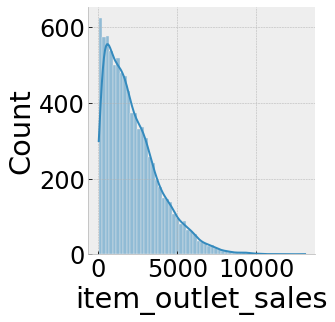

In [19]:
sns.displot(data=df1, x="item_outlet_sales", kde=True)
plt.show()

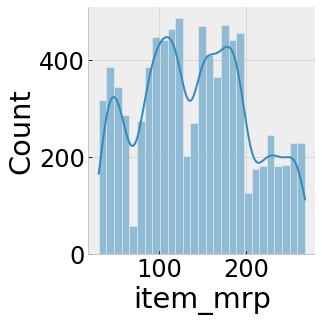

In [20]:
sns.displot(data=df1, x="item_mrp", kde=True)
plt.show()

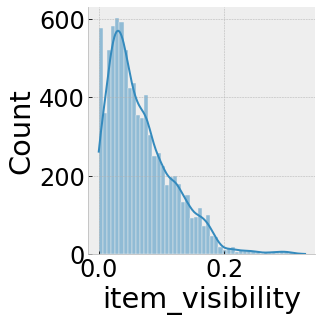

In [21]:
sns.displot(data=df1, x="item_visibility", kde=True)
plt.show()

### 1.6.2 Categorical Attributes 

In [22]:
cat_attributes.apply(lambda x: x.unique(). shape[0])

item_identifier         1559
item_fat_content           5
item_type                 16
outlet_identifier         10
outlet_size                3
outlet_location_type       3
outlet_type                4
dtype: int64

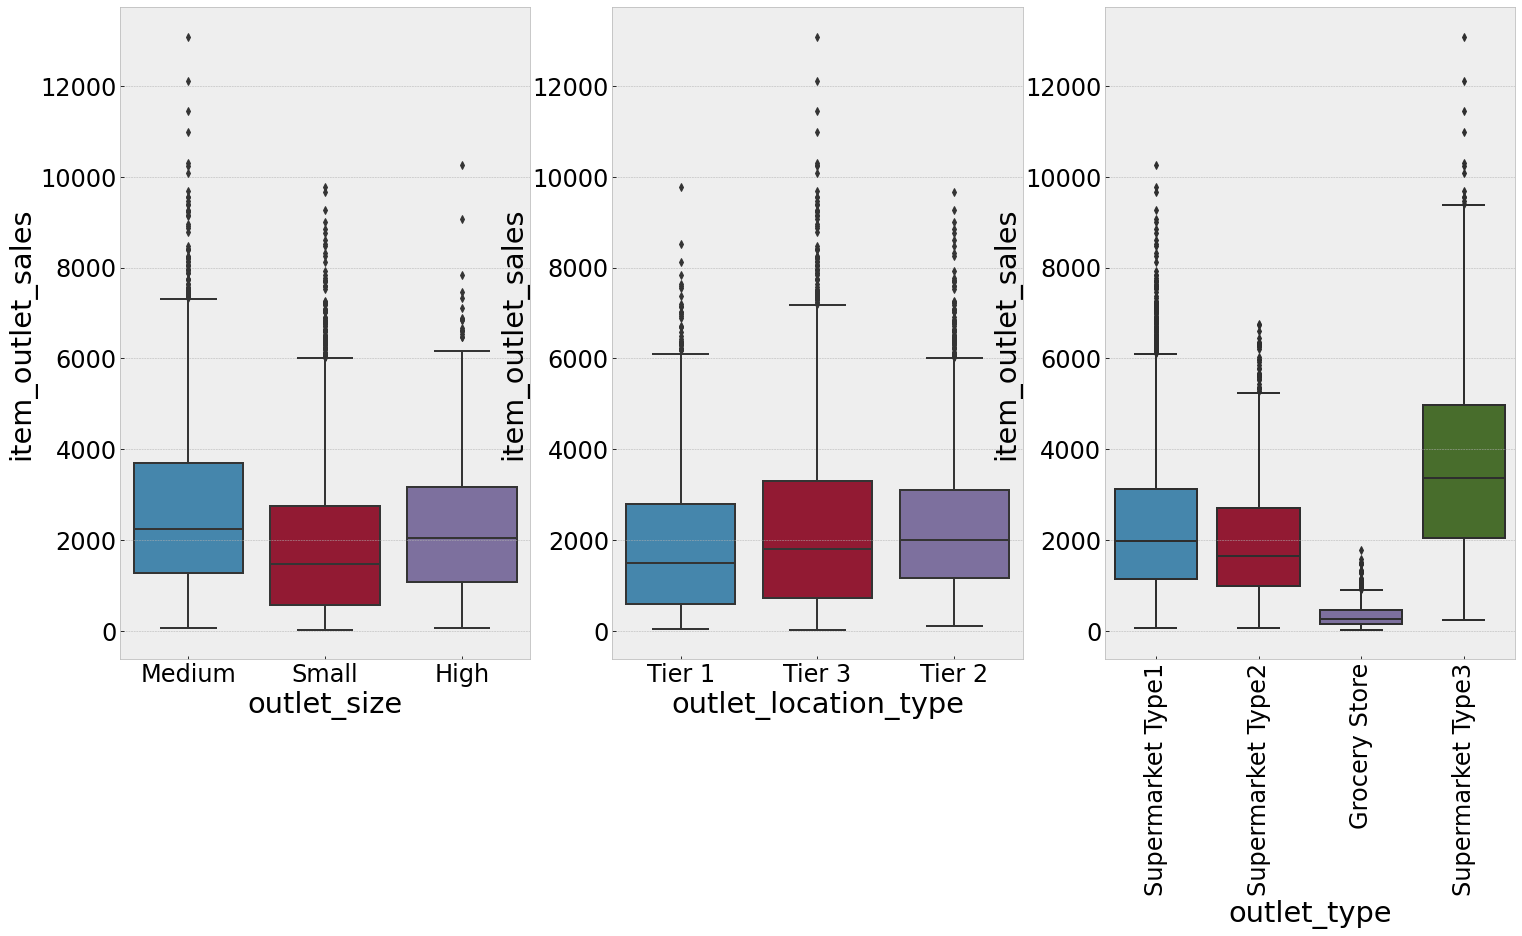

In [24]:
#==========outlet==============
plt.subplot(1,3,1)
sns.boxplot(x='outlet_size', y='item_outlet_sales', data=df1)

plt.subplot(1,3,2)
sns.boxplot(x='outlet_location_type', y='item_outlet_sales', data=df1)

plt.subplot(1,3,3)
sns.boxplot(x='outlet_type', y='item_outlet_sales', data=df1)
plt.xticks(rotation=90);

plt.show()

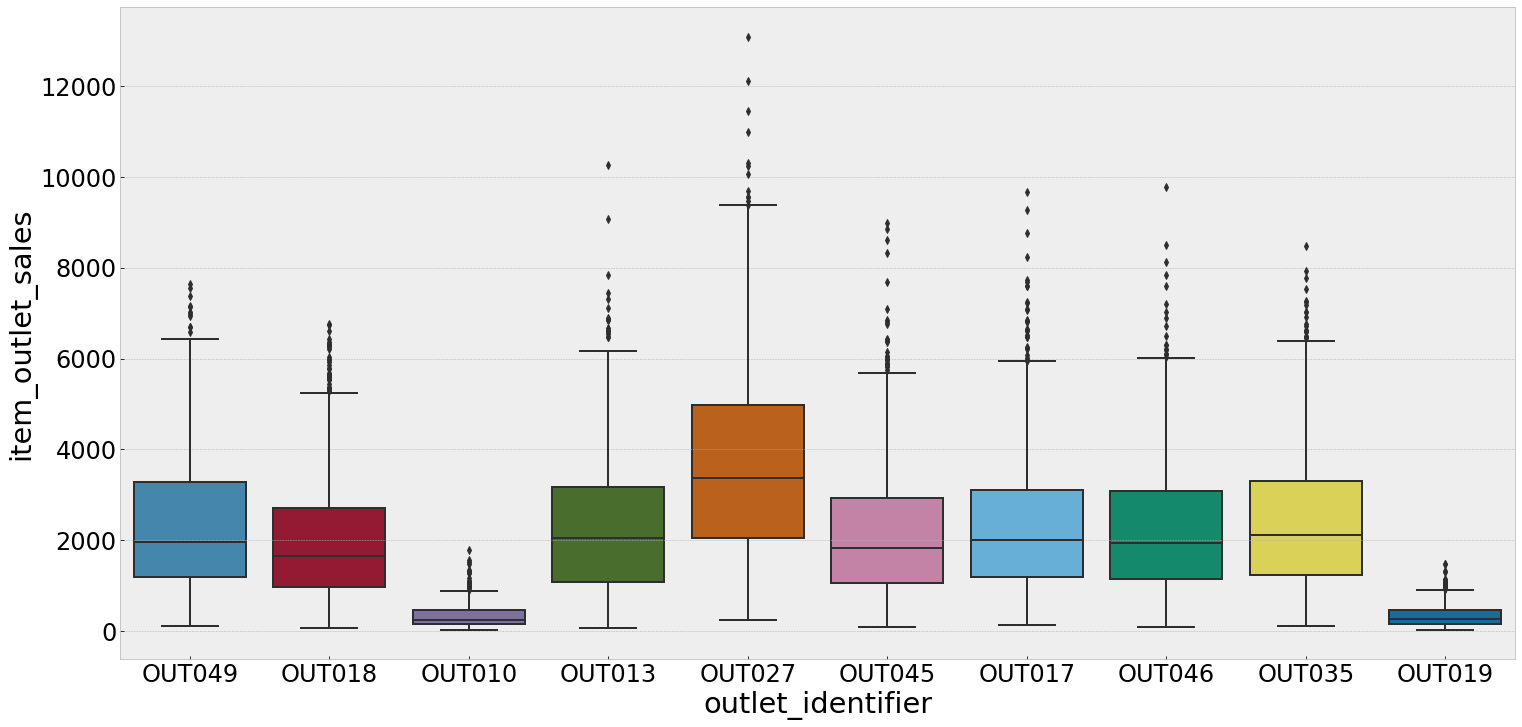

In [25]:
sns.boxplot(x='outlet_identifier', y='item_outlet_sales', data=df1)
plt.show()

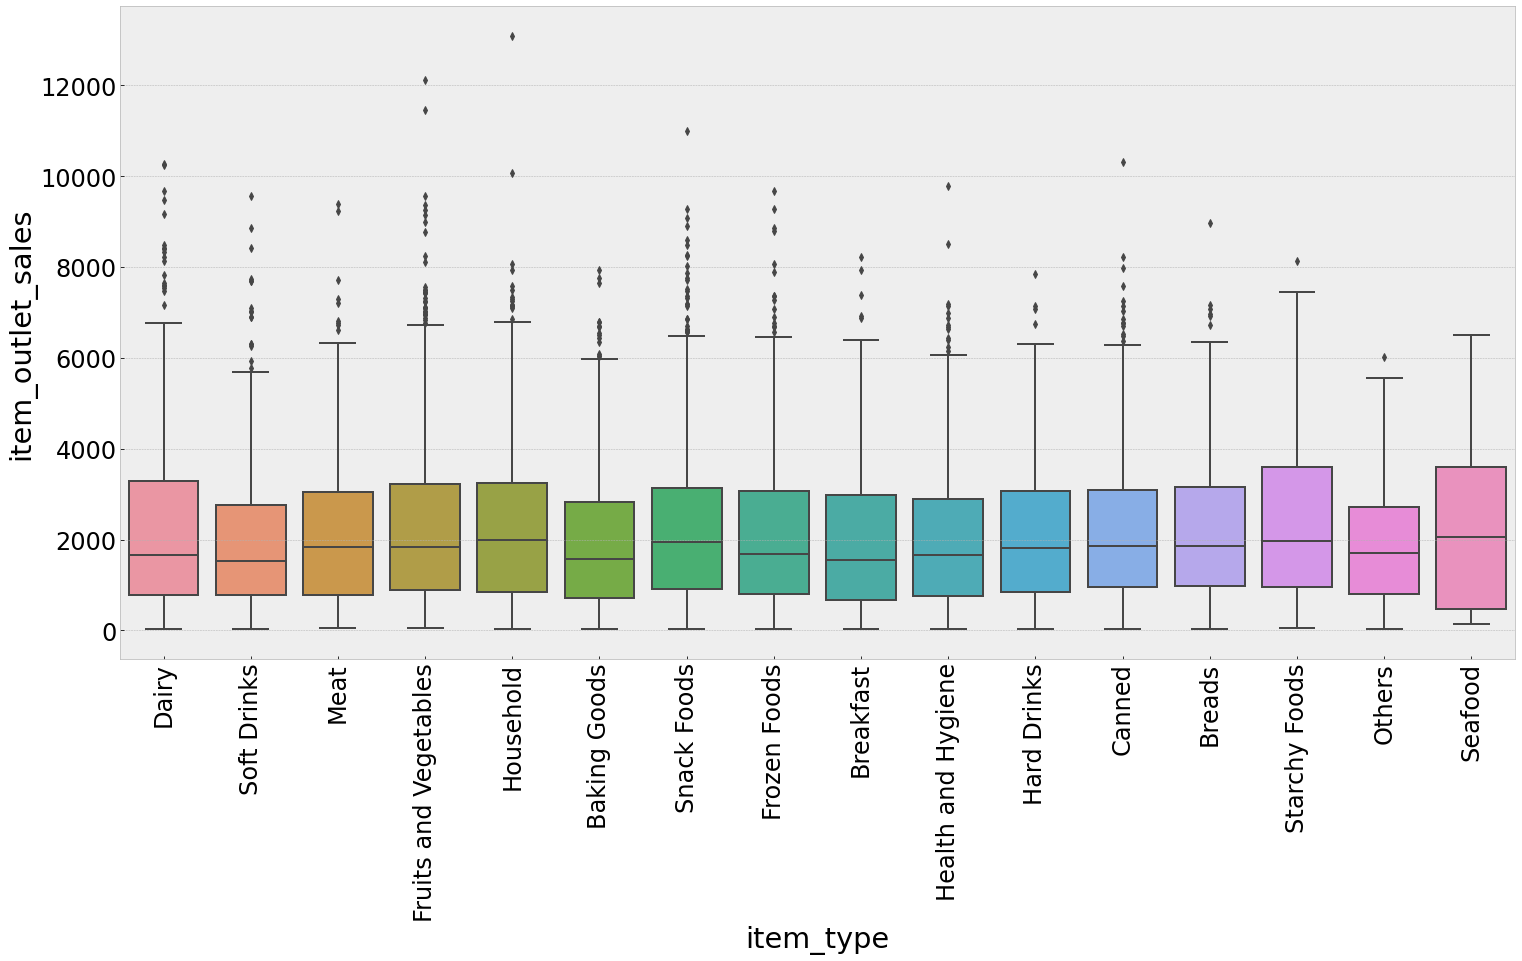

In [27]:
sns.boxplot(x='item_type', y='item_outlet_sales', data=df1)
plt.xticks(rotation=90);
plt.show()

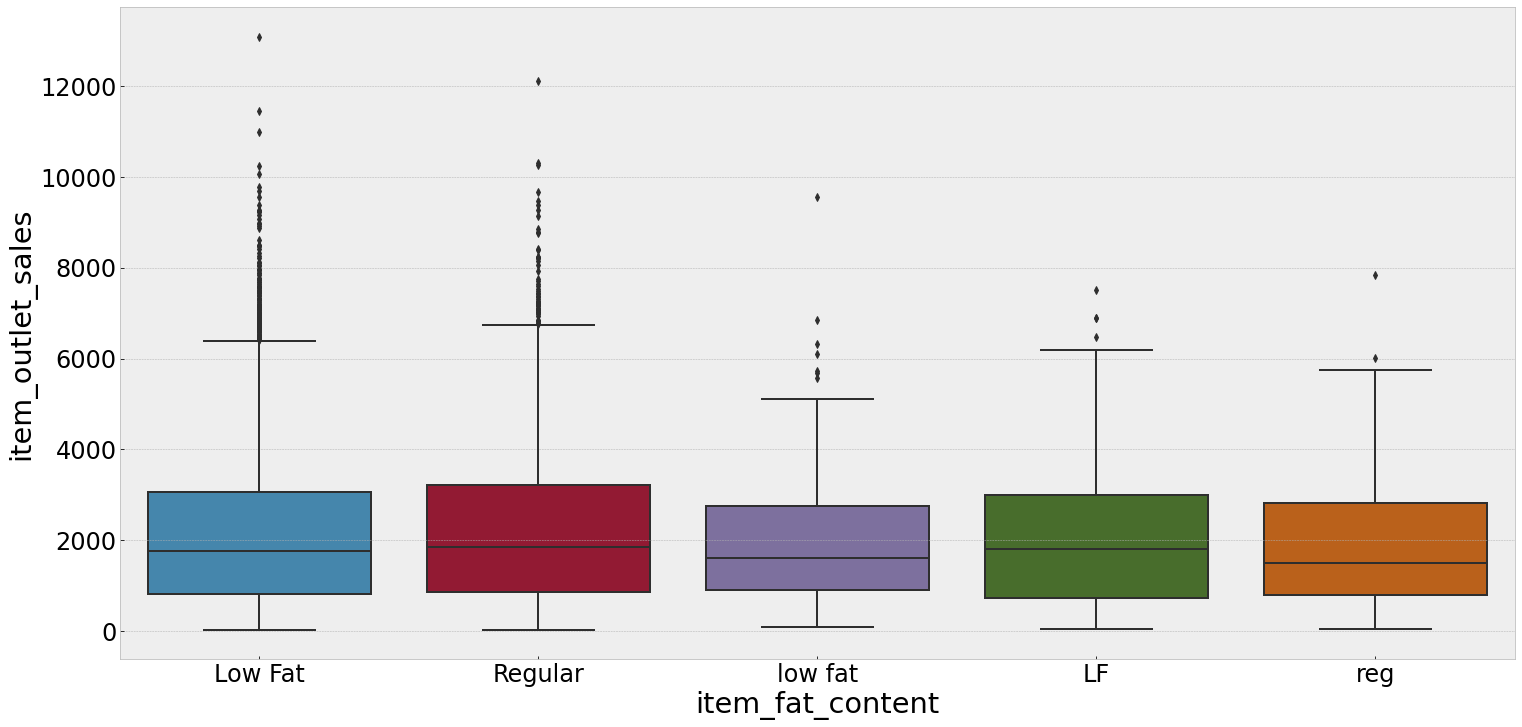

In [28]:
sns.boxplot(x='item_fat_content', y='item_outlet_sales', data=df1)
plt.show()

# 2.0 - FEATURE ENGINEERING

In [29]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map 

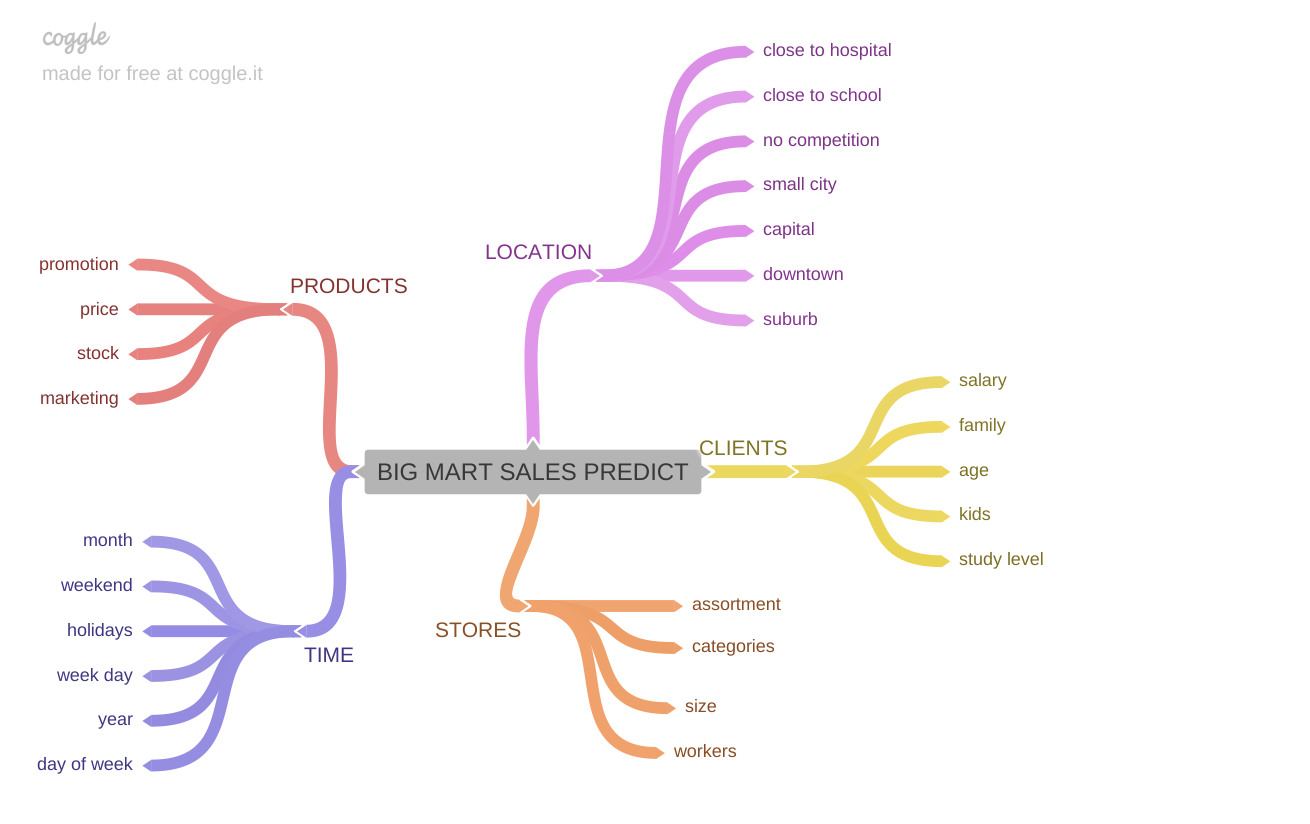

In [31]:
Image('img/mindmap.png')

## 2.2 Hypothesis 

### 2.1.1 Outlet hypothesis 

**H1** Bigger outlets should sell more.

**H2** Tier 3 location outlets shoul sell more.

**H3** Supermarket Type1 is the outlet type with more sales.

**H4** Older outlets should sell more.

### 2.1.2 Item hypothesis 

**H5** Regular fat items should sell more.

**H6** Items with bigger visibility should sell more.

**H7** Household items should be more expensive.

**H8** Expensive products should sell less.

**H9** Lighter items should cost less.

**H10** Heavier items should sell less.

### 2.1.3 Time hypothesis 

**H11** Outlets should sell more over the years.

**H12** Weekends should have less sales then weekdays.

**H13** Outlets should sell more in the last quarter of the year.

**H14** Items MRP should increase over the years.

**H15** Items visibility should increase over the years.

## 2.3 Final Hypothesis List 

**H1** Bigger outlets should sell more.

**H2** Tier 3 location outlets shoul sell more.

**H3** Supermarket Type1 is the outlet type with more sales.

**H4** Older outlets should sell more.

**H5** Regular fat items should sell more.

**H6** Items with bigger visibility should sell more.

**H7** Household items should be more expensive.

**H8** Expensive products should sell less.

**H9** Lighter items should cost less.

**H10** Heavier items should sell less.

**H11** Outlets should sell more over the years.

**H12** Items MRP should increase over the years.

**H13** Items visibility should increase over the years.

## 2.4 Feature Engineering 

# 3.0 - EXPLORATION DATA ANALYSIS (EDA)

In [38]:
df3 = df2.copy()

## 3.1 Univariable Analysis 

### 3.1.1 Response Variable 

C:\Users\Giovana\anaconda3\envs\big_mart_sales_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


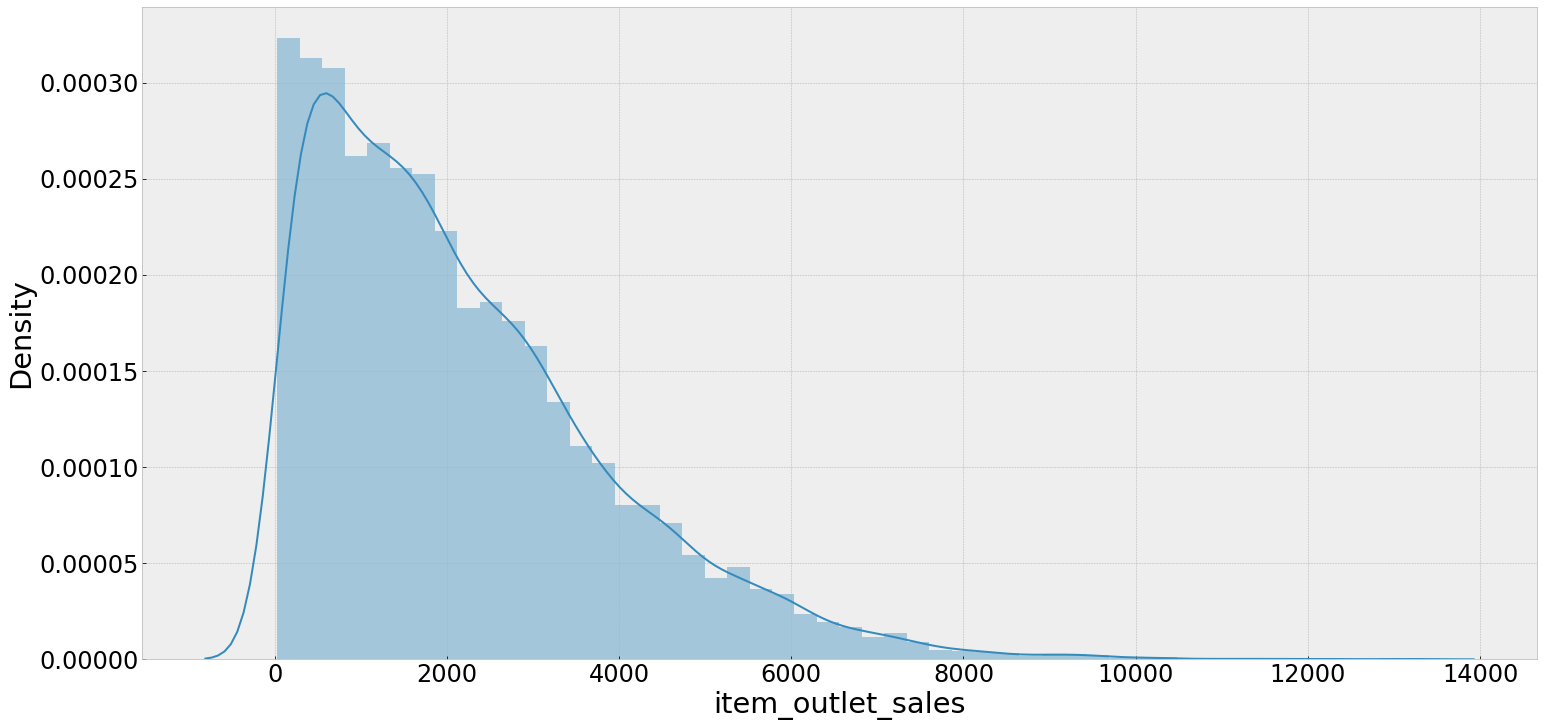

In [45]:
sns.distplot(df3['item_outlet_sales']);

### 3.1.2 Numerical Variables

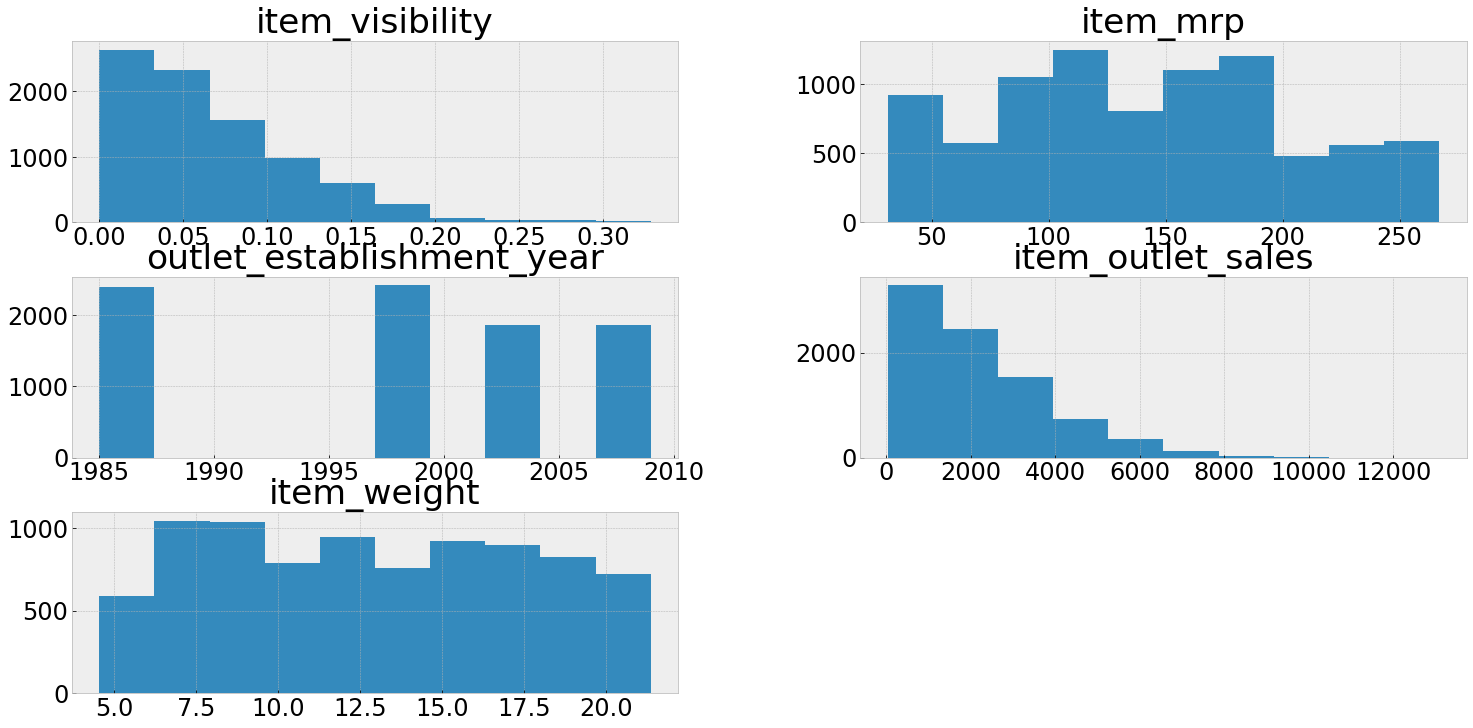

In [47]:
num_attributes.hist();

### 3.1.3 Categorical Variables 

In [51]:
df3['item_identifier'].drop_duplicates()

0       FDA15
1       DRC01
2       FDN15
3       FDX07
4       NCD19
5       FDP36
6       FDO10
7       FDP10
8       FDH17
9       FDU28
10      FDY07
11      FDA03
12      FDX32
13      FDS46
14      FDF32
15      FDP49
16      NCB42
18      DRI11
19      FDU02
20      FDN22
21      FDW12
22      NCB30
23      FDC37
24      FDR28
25      NCD06
26      FDV10
27      DRJ59
28      FDE51
29      FDC14
30      FDV38
31      NCS17
32      FDP33
33      FDO23
34      DRH01
35      NCX29
36      FDV20
37      DRZ11
38      FDX10
39      FDB34
41      FDK43
42      FDA46
43      FDC02
44      FDL50
45      FDM39
46      NCP05
47      FDV49
48      FDL12
49      FDS02
50      NCL17
51      FDM40
52      FDR13
53      FDA43
54      NCP18
55      FDK21
56      NCX54
57      DRK35
58      FDY21
59      FDI26
60      FDM20
61      FDV27
62      FDF09
63      FDY40
64      FDY45
65      FDC46
66      FDH19
67      FDZ03
68      DRH37
69      NCI17
70      FDJ58
72      FDH35
73      FDG02
74    